In [171]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

Let's load the dataset from previos step - cleansed data

In [172]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import zscore, ks_2samp

df_fe = pd.read_pickle("IntermidiateData/3_Final_Cancer_Data.pkl")

In [173]:
df_fe.head()
df_fe.shape

(569, 31)

# Label encoding and normalization 
 This is the only non-continuous feature in the dataset.

In [174]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
# Label encode the 'diagnosis' column
df_fe['diagnosis'] = label_encoder.fit_transform(df_fe['diagnosis'])
# Print the updated dataframe
display(df_fe.head(2))

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


From now and on , when target variable is numberic (mapped 1: malignant , 0: benine) - it can be used with various models for prediction and feature selection.     
Some of the above models are sensitive to diffierences in feature data scalas (like we see before with radius_mean and area_mean where max values ratio is about 100 times)
Normalization on data also makes some algorigthms that sensitive to data scales to perform better and be more robust.    
Lets visualize the face that normalization doesn't change data distribution neither data correlation , it is safe manipulation for the purpose of classification or prediction. Let's use a pair of features from the dataset to examine any changes in correlation and distribution before and after transformation 

In [175]:
from sklearn.preprocessing import MinMaxScaler
# Normalize using Min-Max Scaling for Values 0-1
scaler = MinMaxScaler()
# Normalize all columns except 'diagnosis'
df_unsuperwised = df_fe.drop('diagnosis', axis=1)
df_normalized = pd.DataFrame(scaler.fit_transform(df_unsuperwised), columns=df_unsuperwised.columns)
display(df_normalized.head(2))

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878


Comparision of area_mean vs. radius_mean before transformation 


independent samples t-test between the two groups area_mean and radius_mean before transformation transformation :
T-statistic:
 43.430444659292505

P-value:
 1.2803234301358701e-243
The difference between the two groups is statistically significant.


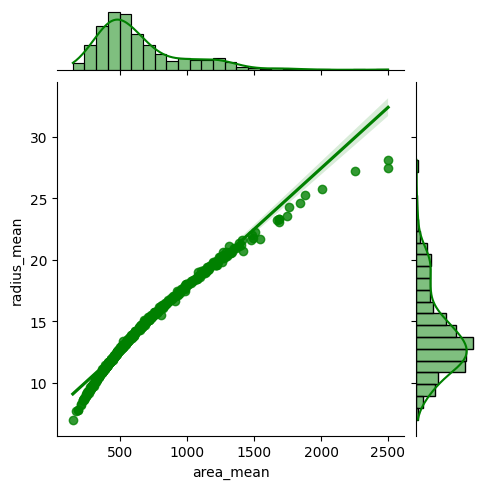

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

def t_test_groups(df, feature1, feature2, timing= 'before transformation'):
    # Perform an independent samples t-test
    t_stat, p_value = stats.ttest_ind(df[feature1], df[feature2])
    # Print the results
    print(f'independent samples t-test between the two groups {feature1} and {feature2} {timing} transformation :') 
    print(f'T-statistic:\n {t_stat}')
    print(f'\nP-value:\n {p_value}')    
    if p_value < 0.05:
        print("The difference between the two groups is statistically significant.")
    else:
        print("The difference between the two groups is not statistically significant.")


def plot_jointplot(df, featurex, featurey , outcomename='diagnosis' , title = 'before transformation'):
    df_info = pd.DataFrame({ 'mean': [df[featurex].mean() , df[featurey].mean()],
                             'std': [df[featurex].std() , df[featurey].std()]})
    df_info.index = [featurex, featurey]
    #display(df_info)   
    print(f'Comparision of {featurex} vs. {featurey} {title} ')
    display(sns.jointplot(x=featurex, y=featurey, data=df, kind='reg', color='green',height=5))
    t_test_groups(df , featurex, featurey , timing= title)


plot_jointplot(df_fe , 'area_mean', 'radius_mean')


Comparision of area_mean vs. radius_mean after transformation 


independent samples t-test between the two groups area_mean and radius_mean after transformation transformation :
T-statistic:
 -12.927103809298954

P-value:
 9.18809847141444e-36
The difference between the two groups is statistically significant.


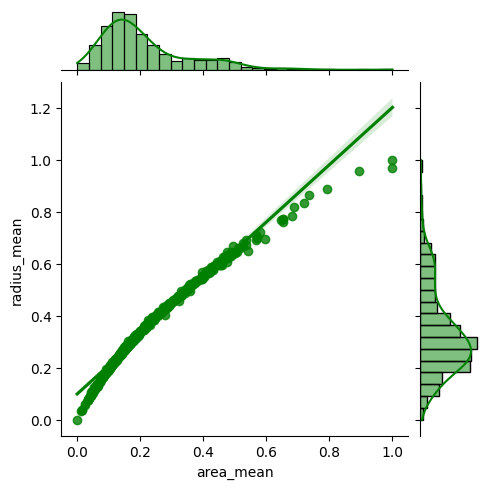

In [177]:
plot_jointplot(df_normalized , 'area_mean', 'radius_mean', title='after transformation')

As seems in the above visualization, neither distribution correlation to a target did not change.
Instead, it seems that the odds of data separation per target class look better after normalization.


As seen in EDA notebook , there is data is balanced enougth (40% malignant and 60% benign) to use the data as is.

# Lets show that this dataset has good chances for classification , using unsuperwised learning

percentages and counts of the target values:


,diagnosis,count
Benign,0,357
Malignant,1,212


Crosstab for the target vs model clustering:


Actual,0,1,Total
Pred,,,
0,1,356,357
1,130,82,212
Total,131,438,569


accuracy:  {0.14586994727592267}
precision_score: 0.1872146118721461
recall_score: 0.3867924528301887
f1_score: 0.2523076923076923
silhouette_score: 0.6972646156059465
area under curve (auc):  0.19479678663918398


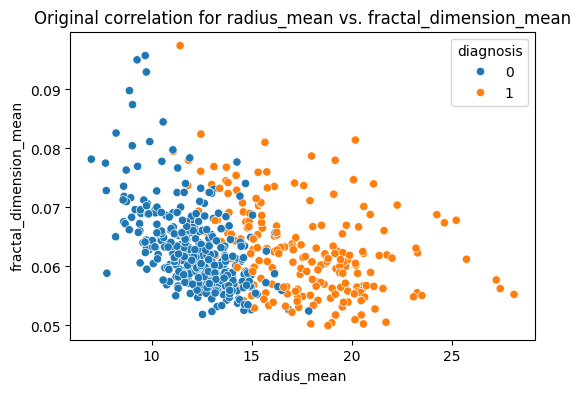

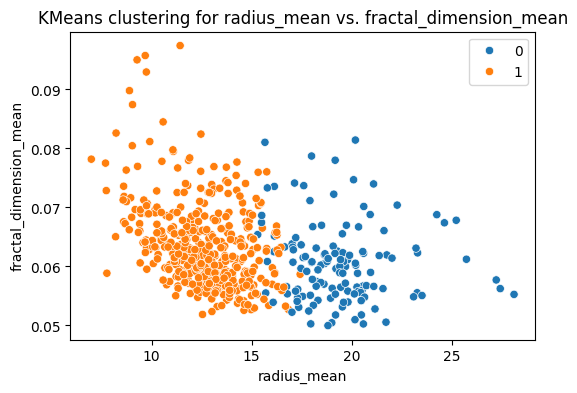

In [178]:
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score , roc_auc_score
from sklearn.metrics import recall_score, accuracy_score , confusion_matrix , precision_score , classification_report


def unsuperwised_performance_metrics(model, df_fe, df_unsuperwised , preds):   
    
    print('Crosstab for the target vs model clustering:')
    #[ True Negative False positive] [ False Negative True Positive ]
    display(pd.crosstab(df_fe['diagnosis'], model.labels_ ,rownames=['Pred'], 
            colnames=['Actual'], margins=True, margins_name="Total"))    
    
    targs = df_fe['diagnosis']
    print("accuracy: ", {accuracy_score(targs, preds)})
    print(f"precision_score: {precision_score(targs, model.labels_)}")
    print(f"recall_score: {recall_score(targs, model.labels_)}")
    print(f"f1_score: {f1_score(targs, model.labels_)}")
    #mean Silhouette Coefficient of all samples.
    print(f"silhouette_score: {silhouette_score(df_unsuperwised, model.labels_)}")
    print(f"area under curve (auc):  {roc_auc_score(targs, preds)}")



target_values = df_fe['diagnosis'].value_counts() 
target_values = pd.Series(target_values)
target_values = pd.DataFrame(target_values)
target_values.reset_index(inplace = True)
target_values.index = ['Benign', 'Malignant']
print('percentages and counts of the target values:')
display(target_values)

def plot_kmeans(df, feature1, feature2, model):
    # Plot the KMeans clustering
    plt.figure(figsize=(10, 6))
    plt.scatter(df[feature1], df[feature2], c=model.labels_, cmap='viridis')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red', marker='x')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'KMeans clustering')
    plt.show()

def try_kmean(df_fe, df_unsuperwised):
    
    kmodel = KMeans(n_clusters=2, random_state=1).fit(df_unsuperwised)    
    preds = kmodel.predict(df_unsuperwised)
    unsuperwised_performance_metrics(kmodel, df_fe, df_unsuperwised , preds)
    fig, axs=plt.subplots(1,1,figsize=(6,4))
    #plot_kmeans(df_unsuperwised, 'radius_mean', 'fractal_dimension_mean', kmodel)   
    
    axs.set_title('KMeans clustering for radius_mean vs. fractal_dimension_mean')
    sns.scatterplot(x=df_unsuperwised['radius_mean'], y=df_unsuperwised['fractal_dimension_mean'],hue=kmodel.labels_, ax=axs)
    
#print('Original correlation for radius_mean vs. fractal_dimension_mean') 
fig, axs=plt.subplots(1,1,figsize=(6,4))
axs.set_title('Original correlation for radius_mean vs. fractal_dimension_mean')
sns.scatterplot(x=df_fe['radius_mean'], y=df_fe['fractal_dimension_mean'],hue=df_fe['diagnosis'], ax=axs)
#df_unsuperwised = df_fe.drop('diagnosis', axis=1)  already done
try_kmean(df_fe,df_unsuperwised)
#try_kmean(df_fe,df_normalized)

Looks like clusters are transposed, but althou if so , 
we can see here that kmeans was good at identification of benign cases (356 out of 357) but terrible identificating (separating) malignancy (130 of 212 - about 60% accuracy ) ,which is bad , especially in medical predictions.
So that  total accuracy , precision , recall and rest of metrics are low. 


Lets try OneClassSVM which also can be used for unsuperwised learning

In [179]:
from sklearn.svm import OneClassSVM
from sklearn.inspection import DecisionBoundaryDisplay


# First need to do a data one-class to use one-class SVM for unsupervised learning
one_class_target = df_fe['diagnosis']
one_class_target = one_class_target.replace({0: 1, 1: -1})
# find the proportion of outliers we expect (aka where `diagnosis == -1`) in the data
# and use that to set the `nu` hyperparameter
outliers = one_class_target[one_class_target == -1]

nu = outliers.shape[0] / one_class_target.shape[0]
print(f"nu: {nu}")

# TBD - plot hyperplan for pairs of features with DecisionBoundaryDisplay.from_estimator
# feature_combinations = list(combinations(df_unsuperwised.columns, 2))
# print(f"Number of feature combinations: {len(feature_combinations)}")
# print("First 5 feature combinations: ", feature_combinations[:5])  

svm = OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)
svm.fit(df_unsuperwised)
preds = svm.predict(df_unsuperwised)
targs = one_class_target 

print('Crosstab for the target vs model one-class SVM:')
#[ True Negative False positive] [ False Negative True Positive ]
display(pd.crosstab(targs, preds ,rownames=['Pred'], 
        colnames=['Actual'], margins=True, margins_name="Total"))    

print("accuracy: ", accuracy_score(targs, preds))
print("precision: ", precision_score(targs, preds)) 
print("recall: ", recall_score(targs, preds))
print("f1: ", f1_score(targs, preds))
print("area under curve (auc): ", roc_auc_score(targs, preds))
#mean Silhouette Coefficient of all samples.
print(f"silhouette_score: {silhouette_score(pd.DataFrame(targs), preds)}")
print(classification_report(targs, preds))


nu: 0.37258347978910367
Crosstab for the target vs model one-class SVM:


Actual,-1,1,Total
Pred,,,
-1,154,58,212
1,53,304,357
Total,207,362,569


accuracy:  0.804920913884007
precision:  0.8397790055248618
recall:  0.8515406162464986
f1:  0.8456189151599444
area under curve (auc):  0.7889778552930606
silhouette_score: 0.4624984312475906
              precision    recall  f1-score   support

          -1       0.74      0.73      0.74       212
           1       0.84      0.85      0.85       357

    accuracy                           0.80       569
   macro avg       0.79      0.79      0.79       569
weighted avg       0.80      0.80      0.80       569



The scores of one-class SVM are better than KMeans clustering , and i am sure it can be futher tuned , but lets stop here and continue to feature selection stage.

# Hyperparameters

## Feature Selection 

### Univariable Feature Selection

We can use here t-tests because it examines relationship between a continuous feature and a binary outcome.
Lets use the K-best to Select features according to the k highest scores.

In [180]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2 , f_classif , f_regression

y=df_fe['diagnosis']
X = df_fe.drop(columns=['diagnosis'])

def univariate_kbest(score_func, num_features):
    # Apply SelectKBest class to extract top 10 best features with Chi-Square tests
    feature_score  = SelectKBest(score_func, k=10).fit(X, y)
    cols = pd.DataFrame(feature_score.scores_ , columns=['Feature_Scores'])
    cols['Feature_Names'] = X.columns
    df_univatiate = cols.nlargest(num_features,'Feature_Scores')
    df_univatiate_columns = df_univatiate.Feature_Names.to_list()
    display(df_univatiate_columns)
    return df_univatiate_columns


n_features = 10
# Apply SelectKBest class to extract top 10 best features with Chi-Square tests
chi2_list = univariate_kbest(chi2, n_features)
# A-Nova
anova_list = univariate_kbest(f_classif, n_features)
# Linear Regression -  returning F-statistic and p-values
lr_list = univariate_kbest(f_regression, n_features)




['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_se',
 'texture_worst',
 'texture_mean']

['concave points_worst',
 'perimeter_worst',
 'concave points_mean',
 'radius_worst',
 'perimeter_mean',
 'area_worst',
 'radius_mean',
 'area_mean',
 'concavity_mean',
 'concavity_worst']

['concave points_worst',
 'perimeter_worst',
 'concave points_mean',
 'radius_worst',
 'perimeter_mean',
 'area_worst',
 'radius_mean',
 'area_mean',
 'concavity_mean',
 'concavity_worst']

### Multivariable Analysis

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier ,AdaBoostRegressor
from sklearn.linear_model import Lasso , Ridge , RidgeClassifierCV , RidgeClassifier , LogisticRegression , LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC


y=df_fe['diagnosis']
X = df_fe.drop(columns=['diagnosis'])

#X = df_unsuperwised 

In [182]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

ridge = Ridge(alpha=0.5).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

lreg = LogisticRegression(max_iter=1000, C=1, penalty='l1', solver='liblinear').fit(X, y)
lreg_selected = (np.abs(lreg.coef_[0]) > 0).astype(int)

linearReg = LinearRegression().fit(X, y)
linearReg_selected = (np.abs(linearReg.coef_) > 0).astype(int)

gb = GradientBoostingClassifier().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

adb = AdaBoostRegressor().fit(X, y)
adb_selected = (adb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'Ridge': ridge_selected,
    'SVM': svm_selected,
    'LinearReg': linearReg_selected,
    'GradientBoost': gb_selected,
    'AdaBoost': adb_selected,
    'RandomForest': rf_selected,
    'LogisticRegression': lreg_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'Ridge', 'SVM', 'LinearReg', 'GradientBoost',  'AdaBoost' , 'RandomForest','LogisticRegression']].sum(axis=1)


As see above , most of the models cannot properly decide on feature importance , maybe because of a higth multicollinearity in dataset  (high corrections between different features) . This doesn't change on normalized X as well. Only lasso , ridge and SVM were able to decide on which features are most important.

In [183]:

# Output the results
display(selection_df)

,Feature,Lasso,Ridge,SVM,LinearReg,GradientBoost,AdaBoost,RandomForest,LogisticRegression,Sum
0,radius_mean,0,1,0,1,1,1,1,1,6
1,texture_mean,1,1,0,1,1,1,1,1,7
2,perimeter_mean,0,1,1,1,1,1,1,1,7
3,area_mean,1,1,1,1,1,1,1,1,8
4,smoothness_mean,0,1,0,1,1,1,1,0,5
5,compactness_mean,0,1,0,1,1,1,1,0,5
6,concavity_mean,0,1,0,1,1,1,1,0,5
7,concave points_mean,0,1,0,1,1,1,1,0,5
8,symmetry_mean,0,1,0,1,1,1,1,0,5
9,fractal_dimension_mean,0,1,0,1,1,1,1,0,5


'Most important features of the dataset : 12'

"['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'texture_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'diagnosis']"

,radius_mean,texture_mean,perimeter_mean,area_mean,texture_se,area_se,radius_worst,texture_worst,perimeter_worst,area_worst,concavity_worst,diagnosis
0,17.99,10.38,122.8,1001.0,0.9053,153.40,25.38,17.33,184.6,2019.0,0.7119,1
1,20.57,17.77,132.9,1326.0,0.7339,74.08,24.99,23.41,158.8,1956.0,0.2416,1


(569, 12)

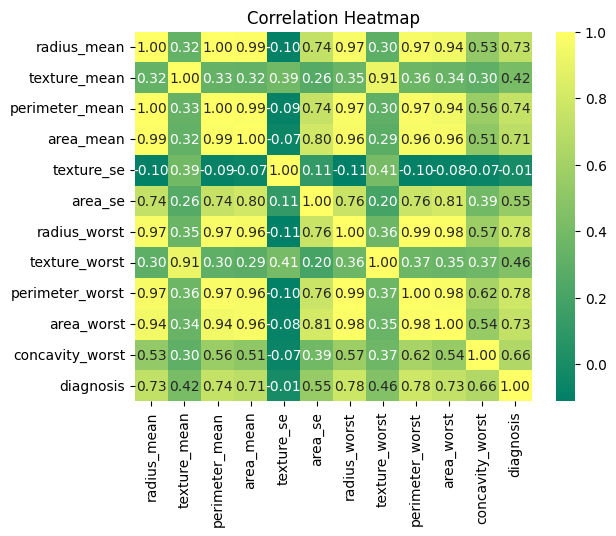

In [184]:
#Selecting variables with a sum of selections >= 6
final_var = selection_df[selection_df['Sum'] >= 6 ]['Feature'].tolist()
df_model = df_fe[final_var].copy()
df_model['diagnosis'] = df_fe['diagnosis'].copy()

columns_list = df_model.columns.tolist()
display(f"Most important features of the dataset : {len(columns_list)}")
display(f"{columns_list}")
display(df_model.head(2))
display(df_model.shape)

df_model.correlation = df_model.corr()
heatmap = sns.heatmap(df_model.corr(), annot=True, cmap='summer', fmt=".2f")  
plt.title('Correlation Heatmap')
plt.show()
#display(df_model.correlation)


In [185]:
# Compare results from univariate and model-based feature selection
chi2_univatiate_columns_set = set(chi2_list)
anova_univatiate_columns_set = set(anova_list)
lr_univatiate_columns_set = set(lr_list)
multivatiate_columns_set = set(df_model.columns.tolist())

def interception_set(set1, set2 , name1, name2):
    interception_set = set1.intersection(set2)
    display(f"Common columns between univariate {name1} and model-based feature selection:")
    display(f"Features : {interception_set} ")
    display(f"Length : {interception_set.__len__()}")
    return interception_set , interception_set.__len__()


dict_choosen_columns = {}

list1, len1 = interception_set(chi2_univatiate_columns_set, multivatiate_columns_set, name1='chi2_univatiate_columns_set', name2='multivatiate_columns_set')
list2, len2 = interception_set(anova_univatiate_columns_set, multivatiate_columns_set, name1='anova_univatiate_columns_set', name2='multivatiate_columns_set')
list3, len3 = interception_set(lr_univatiate_columns_set, multivatiate_columns_set, name1='lr_univatiate_columns_set', name2='multivatiate_columns_set')
print(multivatiate_columns_set)
print(len(multivatiate_columns_set))


# We'll choose the features that are common to all three sets - chi2, anova, lr  and multivariate - and this is most close 
# to the ch2 list


'Common columns between univariate chi2_univatiate_columns_set and model-based feature selection:'

"Features : {'perimeter_worst', 'area_worst', 'radius_worst', 'texture_mean', 'radius_mean', 'perimeter_mean', 'area_se', 'texture_worst', 'area_mean'} "

'Length : 9'

'Common columns between univariate anova_univatiate_columns_set and model-based feature selection:'

"Features : {'perimeter_worst', 'area_worst', 'radius_worst', 'radius_mean', 'perimeter_mean', 'concavity_worst', 'area_mean'} "

'Length : 7'

'Common columns between univariate lr_univatiate_columns_set and model-based feature selection:'

"Features : {'perimeter_worst', 'area_worst', 'radius_worst', 'radius_mean', 'perimeter_mean', 'concavity_worst', 'area_mean'} "

'Length : 7'

{'perimeter_worst', 'radius_worst', 'area_worst', 'diagnosis', 'texture_mean', 'radius_mean', 'texture_se', 'perimeter_mean', 'area_se', 'texture_worst', 'concavity_worst', 'area_mean'}
12


### Dimensionality reduction with PCA
According to the correlations matrix , the problem of multicollinearity is still here , as out of 9 selected features (each got at least 5 common votes as important one) - there are still many features  with high correlations.
Rather than dropping some of the high-correlating features , we can use PCA - which will engeneer a few new features (components) which include most of the data variablity found in the dataset.

(30, 30)


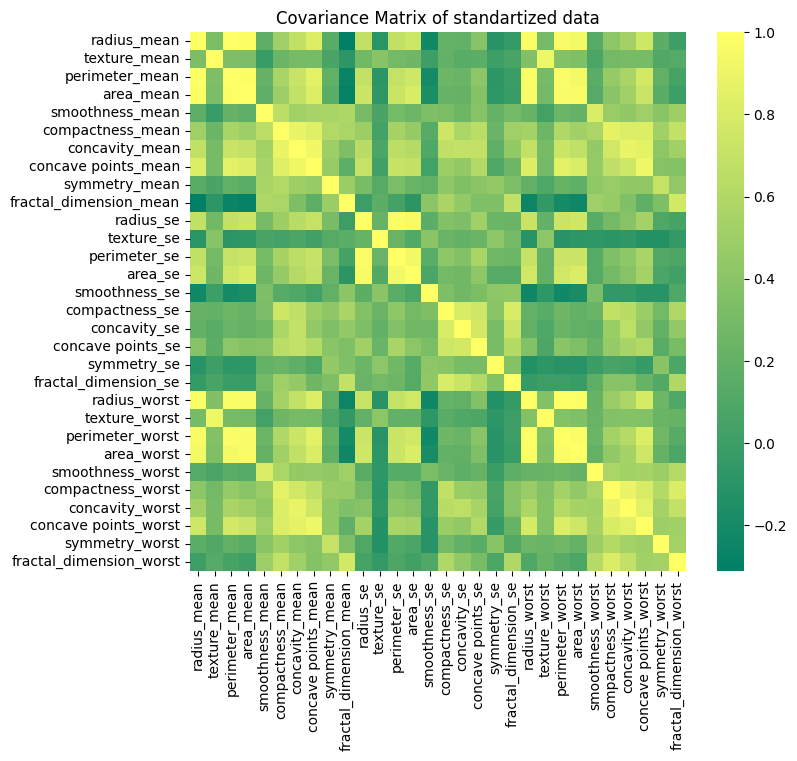

Eigen values:
 [1.32816077e+01 5.69135461e+00 2.81794898e+00 1.98064047e+00
 1.64873055e+00 1.20735661e+00 6.75220114e-01 4.76617140e-01
 4.16894812e-01 3.50693457e-01 2.93915696e-01 2.61161370e-01
 2.41357496e-01 1.57009724e-01 9.41349650e-02 7.98628010e-02
 5.93990378e-02 5.26187835e-02 4.94775918e-02 1.33044823e-04
 7.48803097e-04 1.58933787e-03 6.90046388e-03 8.17763986e-03
 1.54812714e-02 1.80550070e-02 2.43408378e-02 2.74394025e-02
 3.11594025e-02 2.99728939e-02]
Eigen values Shape: (30,)
Eigen Vector Shape: (30, 30)
5


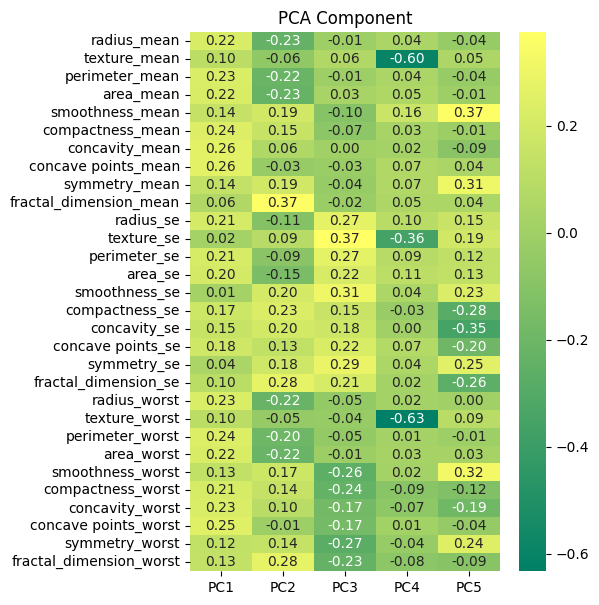

In [186]:
from sklearn.decomposition import PCA

# PCA is sensitive to the scale of the data. Therefore, we need to standardize the data before applying PCA.
X_mean = df_unsuperwised.mean()
# Standard deviation
X_std = df_unsuperwised.std()
# Standardization
Z = (df_unsuperwised - X_mean) / X_std
# covariance
c = Z.cov()
print(c.shape)

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(8, 7))
sns.heatmap(c, cmap='summer' , fmt=".2f")
plt.title('Covariance Matrix of standartized data')
plt.show()

#compute the eigenvectors and eigenvalues for our features , this is important for identifying the principal components for our feature space.
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

# Sort the eigenvalues in descending order and sort the corresponding eigenvectors accordingly.
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]
# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]
# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]
# the amount of the total variance which has been retained by selecting the principal components instead of the original feature space.
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

#considering explained variance more than equal to 80%. 
# Let’s check how many principal components come into this.
n_components = np.argmax(explained_var >= 0.80) + 1
print(n_components)
columns = ['PC'+str(i) for i in range(1,n_components+1)]

# PCA component or unit matrix
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
                             index = df_unsuperwised.columns,
                             columns = columns
                            )

# plotting heatmap
pca_component.shape
pca_component.head(2)
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component, annot=True, cmap='summer', fmt=".2f")
plt.title('PCA Component')
plt.show()




Here from the plot we can see that two PCA components can explain up to 0.998 of data variance in dataset , so that the multicollinearity problem should be corrected.

           PC1        PC2       PC3       PC4       PC5
0     9.184755   1.946870 -1.122179  3.630536 -1.194060
1     2.385703  -3.764859 -0.528827  1.117281  0.621229
2     5.728855  -1.074229 -0.551263  0.911281 -0.176930
3     7.116691  10.266556 -3.229948  0.152413 -2.958275
4     3.931842  -1.946359  1.388545  2.938054  0.546267
..         ...        ...       ...       ...       ...
564   6.433655  -3.573673  2.457324  1.176279 -0.074759
565   3.790048  -3.580897  2.086640 -2.503825 -0.510273
566   1.255075  -1.900624  0.562236 -2.087390  1.808400
567  10.365673   1.670540 -1.875379 -2.353960 -0.033712
568  -5.470430  -0.670047  1.489133 -2.297136 -0.184541

[569 rows x 5 columns]
 explained_variance_ratio_: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768]
 total explained_variance_ratio_: 0.8473427431679251
 total components : 5


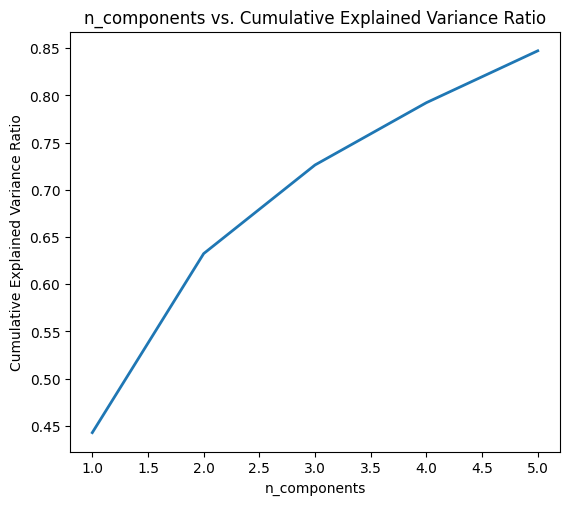

In [187]:
# Same using sklearn
pca = PCA(n_components=n_components)
pca.fit(Z)
x_pca = pca.transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
                       columns=['PC{}'.
                       format(i+1)
                        for i in range(n_components)])
print(df_pca1)

print(f" explained_variance_ratio_: {pca.explained_variance_ratio_}")
transformed_pca = pca.transform(df_unsuperwised)
print(f" total explained_variance_ratio_: {sum(pca.explained_variance_ratio_)}")
print(f" total components : {pca.components_.shape[0]}")

plt.figure(2, figsize=(7, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(range(1, pca.components_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('n_components vs. Cumulative Explained Variance Ratio')
plt.show()

# Save to a pkl - feature engeneering 

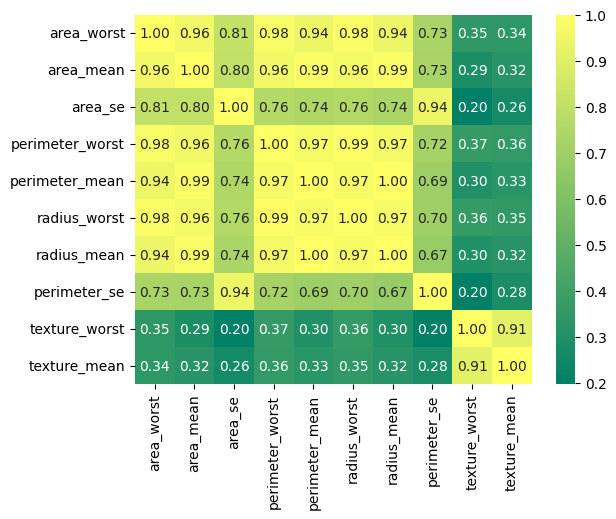

In [190]:

final_choose_columns = chi2_list
df_model = df_fe[final_choose_columns].copy()
sns.heatmap(df_model.corr(), annot=True, cmap='summer', fmt=".2f")
df_model.to_pickle('IntermidiateData/4_FeatureEngeneering_Cancer_Data.pkl')